# Exploring a file

[uproot.open](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-open) is the entry point for reading a single file.

It takes a local filename path or a remote `http://` or `root://` URL. (HTTP requires the Python [requests](https://pypi.org/project/requests/) library and XRootD requires [pyxrootd](http://xrootd.org/), both of which have to be explicitly pip-installed if you installed uproot with pip, but are automatically installed if you installed uproot with conda.)

In [1]:
import uproot

file = uproot.open("http://scikit-hep.org/uproot/examples/nesteddirs.root")
file

<ROOTDirectory b'tests/nesteddirs.root' at 0x78fbc81640b8>

[uproot.open](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-open) returns a [uproot.rootio.ROOTDirectory](https://uproot.readthedocs.io/en/latest/root-io.html#uproot-rootio-rootdirectory), which behaves like a Python dict; it has `keys()`, `values()`, and key-value access with square brackets.

In [2]:
file.keys()

[b'one;1', b'three;1']

In [3]:
file["one"]

<ROOTDirectory b'one' at 0x78fbc81645c0>

Subdirectories also have type [uproot.rootio.ROOTDirectory](https://uproot.readthedocs.io/en/latest/root-io.html#uproot-rootio-rootdirectory), so they behave like Python dicts, too.

In [4]:
file["one"].keys()

[b'two;1', b'tree;1']

In [5]:
file["one"].values()

[<ROOTDirectory b'two' at 0x78fbc8164a20>, <TTree b'tree' at 0x78fbc81648d0>]

**What's the `b` before each object name?** Python 3 distinguishes between bytestrings and encoded strings. ROOT object names have no encoding, such as Latin-1 or Unicode, so uproot presents them as raw bytestrings. However, if you enter a Python string (no `b`) and it matches an object name (interpreted as plain ASCII), it will count as a match, as `"one"` does above.

**What's the `;1` after each object name?** ROOT objects are versioned with a "cycle number." If multiple objects are written to the ROOT file with the same name, they will have different cycle numbers, with the largest value being last. If you don't specify a cycle number, you'll get the latest one.

This file is deeply nested, so while you could find the TTree with

In [6]:
file["one"]["two"]["tree"]

<TTree b'tree' at 0x78fbc8164e10>

you can also find it using a directory path, with slashes.

In [7]:
file["one/two/tree"]

<TTree b'tree' at 0x78fbe49e3cc0>

Here are a few more tricks for finding your way around a file:

   * the `keys()`, `values()`, and `items()` methods have `allkeys()`, `allvalues()`, `allitems()` variants that recursively search through all subdirectories;
   * all of these functions can be filtered by name or class: see [uproot.rootio.ROOTDirectory.keys](https://uproot.readthedocs.io/en/latest/root-io.html#uproot.rootio.ROOTDirectory.keys).

Here's how you would search the subdirectories to find all TTrees:

In [8]:
file.allkeys(filterclass=lambda cls: issubclass(cls, uproot.tree.TTreeMethods))

[b'one/two/tree;1', b'one/tree;1', b'three/tree;1']

Or get a Python dict of them:

In [9]:
all_ttrees = dict(file.allitems(filterclass=lambda cls: issubclass(cls, uproot.tree.TTreeMethods)))
all_ttrees

{b'one/two/tree;1': <TTree b'tree' at 0x78fbc811b908>,
 b'one/tree;1': <TTree b'tree' at 0x78fbc811bc88>,
 b'three/tree;1': <TTree b'tree' at 0x78fbc811b860>}

Be careful: Python 3 is not as forgiving about matching key names. `all_ttrees` is a plain Python dict, so the key must be a bytestring and must include the cycle number.

In [10]:
all_ttrees[b"one/two/tree;1"]

<TTree b'tree' at 0x78fbc811b908>

## Exploring a TTree

TTrees are special objects in ROOT files: they contain most of the physics data. Uproot presents TTrees as subclasses of [uproot.tree.TTreeMethods](https://uproot.readthedocs.io/en/latest/ttree-handling.html#uproot-tree-ttreemethods).

(**Why subclass?** Different ROOT files can have different versions of a class, so uproot generates Python classes to fit the data, as needed. All TTrees inherit from [uproot.tree.TTreeMethods](https://uproot.readthedocs.io/en/latest/ttree-handling.html#uproot-tree-ttreemethods) so that they get the same data-reading methods.)

In [11]:
events = uproot.open("http://scikit-hep.org/uproot/examples/Zmumu.root")["events"]
events

<TTree b'events' at 0x78fbc80c5dd8>

Although [uproot.tree.TTreeMethods](https://uproot.readthedocs.io/en/latest/ttree-handling.html#uproot-tree-ttreemethods) objects behave like Python dicts of [uproot.tree.TBranchMethods](https://uproot.readthedocs.io/en/latest/ttree-handling.html#uproot-tree-tbranchmethods) objects, the easiest way to browse a TTree is by calling its `show()` method, which prints the branches and their interpretations as arrays.

In [12]:
events.keys()

[b'Type',
 b'Run',
 b'Event',
 b'E1',
 b'px1',
 b'py1',
 b'pz1',
 b'pt1',
 b'eta1',
 b'phi1',
 b'Q1',
 b'E2',
 b'px2',
 b'py2',
 b'pz2',
 b'pt2',
 b'eta2',
 b'phi2',
 b'Q2',
 b'M']

In [13]:
events.show()

Type                       (no streamer)              asstring()
Run                        (no streamer)              asdtype('>i4')
Event                      (no streamer)              asdtype('>i4')
E1                         (no streamer)              asdtype('>f8')
px1                        (no streamer)              asdtype('>f8')
py1                        (no streamer)              asdtype('>f8')
pz1                        (no streamer)              asdtype('>f8')
pt1                        (no streamer)              asdtype('>f8')
eta1                       (no streamer)              asdtype('>f8')
phi1                       (no streamer)              asdtype('>f8')
Q1                         (no streamer)              asdtype('>i4')
E2                         (no streamer)              asdtype('>f8')
px2                        (no streamer)              asdtype('>f8')
py2                        (no streamer)              asdtype('>f8')
pz2                        (no streame

Basic information about the TTree, such as its number of entries, are available as properties.

In [14]:
events.name, events.title, events.numentries

(b'events', b'Z -> mumu events', 2304)

# Reading arrays from a TTree

The bulk data in a TTree are not read until requested. There are many ways to do that:

   * select a TBranch and call [TBranchMethods.array](https://uproot.readthedocs.io/en/latest/ttree-handling.html#id11);
   * call [TTreeMethods.array](https://uproot.readthedocs.io/en/latest/ttree-handling.html#array) directly from the TTree object;
   * call [TTreeMethods.arrays](https://uproot.readthedocs.io/en/latest/ttree-handling.html#arrays) to get several arrays at a time;
   * call [TBranch.lazyarray](https://uproot.readthedocs.io/en/latest/ttree-handling.html#id13), [TTreeMethods.lazyarray](https://uproot.readthedocs.io/en/latest/ttree-handling.html#lazyarray), [TTreeMethods.lazyarrays](https://uproot.readthedocs.io/en/latest/ttree-handling.html#lazyarrays), or [uproot.lazyarrays](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-lazyarray-and-lazyarrays) to get array-like objects that read on demand;
   * call [TTreeMethods.iterate](https://uproot.readthedocs.io/en/latest/ttree-handling.html#iterate) or [uproot.iterate](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-iterate) to explicitly iterate over chunks of data (to avoid reading more than would fit into memory);
   * call [TTreeMethods.pandas](https://uproot.readthedocs.io/en/latest/ttree-handling.html#id7) or [uproot.pandas.iterate](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-pandas-iterate) to get Pandas DataFrames ([Pandas](https://pandas.pydata.org/) must be installed).

Let's start with the simplest.

In [15]:
a = events.array("E1")
a

array([82.20186639, 62.34492895, 62.34492895, ..., 81.27013558,
       81.27013558, 81.56621735])

Since `array` is singular, you specify one branch name and get one array back. This is a [Numpy array](https://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html) of 8-byte floating point numbers, the [Numpy dtype](https://docs.scipy.org/doc/numpy/reference/arrays.dtypes.html) specified by the `"E1"` branch's interpretation.

In [16]:
events["E1"].interpretation

asdtype('>f8')

We can use this array in Numpy calculations; see the [Numpy documentation](https://docs.scipy.org/doc/numpy/) for details.

In [17]:
import numpy

numpy.log(a)

array([4.40917801, 4.13268234, 4.13268234, ..., 4.39777861, 4.39777861,
       4.40141517])

Numpy arrays are also the standard container for entering data into machine learning frameworks; see this [Keras introduction](https://keras.io/), [PyTorch introduction](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html), [TensorFlow introduction](https://www.tensorflow.org/guide/low_level_intro), or [Scikit-Learn introduction](https://scikit-learn.org/stable/tutorial/basic/tutorial.html) to see how to put Numpy arrays to work in machine learning.

The [TBranchMethods.array](https://uproot.readthedocs.io/en/latest/ttree-handling.html#id11) method is the same as [TTreeMethods.array](https://uproot.readthedocs.io/en/latest/ttree-handling.html#array) except that you don't have to specify the TBranch name (naturally). Sometimes one is more convenient, sometimes the other.

In [18]:
events.array("E1"), events["E1"].array()

(array([82.20186639, 62.34492895, 62.34492895, ..., 81.27013558,
        81.27013558, 81.56621735]),
 array([82.20186639, 62.34492895, 62.34492895, ..., 81.27013558,
        81.27013558, 81.56621735]))

The plural `arrays` method is different. Whereas singular `array` could only return one array, plural `arrays` takes a list of names (possibly including wildcards) and returns them all in a Python dict.

In [19]:
events.arrays(["px1", "py1", "pz1"])

{b'px1': array([-41.19528764,  35.11804977,  35.11804977, ...,  32.37749196,
         32.37749196,  32.48539387]),
 b'py1': array([ 17.4332439 , -16.57036233, -16.57036233, ...,   1.19940578,
          1.19940578,   1.2013503 ]),
 b'pz1': array([-68.96496181, -48.77524654, -48.77524654, ..., -74.53243061,
        -74.53243061, -74.80837247])}

In [20]:
events.arrays(["p[xyz]*"])

{b'px1': array([-41.19528764,  35.11804977,  35.11804977, ...,  32.37749196,
         32.37749196,  32.48539387]),
 b'py1': array([ 17.4332439 , -16.57036233, -16.57036233, ...,   1.19940578,
          1.19940578,   1.2013503 ]),
 b'pz1': array([-68.96496181, -48.77524654, -48.77524654, ..., -74.53243061,
        -74.53243061, -74.80837247]),
 b'px2': array([ 34.14443725, -41.19528764, -40.88332344, ..., -68.04191497,
        -68.79413604, -68.79413604]),
 b'py2': array([-16.11952457,  17.4332439 ,  17.29929704, ..., -26.10584737,
        -26.39840043, -26.39840043]),
 b'pz2': array([ -47.42698439,  -68.96496181,  -68.44725519, ..., -152.2350181 ,
        -153.84760383, -153.84760383])}

As with all ROOT object names, the TBranch names are bytestrings (prepended by `b`). If you know the encoding or it doesn't matter (`"ascii"` and `"utf-8"` are generic), pass a `namedecode` to get keys that are strings.

In [21]:
events.arrays(["p[xyz]*"], namedecode="utf-8")

{'px1': array([-41.19528764,  35.11804977,  35.11804977, ...,  32.37749196,
         32.37749196,  32.48539387]),
 'py1': array([ 17.4332439 , -16.57036233, -16.57036233, ...,   1.19940578,
          1.19940578,   1.2013503 ]),
 'pz1': array([-68.96496181, -48.77524654, -48.77524654, ..., -74.53243061,
        -74.53243061, -74.80837247]),
 'px2': array([ 34.14443725, -41.19528764, -40.88332344, ..., -68.04191497,
        -68.79413604, -68.79413604]),
 'py2': array([-16.11952457,  17.4332439 ,  17.29929704, ..., -26.10584737,
        -26.39840043, -26.39840043]),
 'pz2': array([ -47.42698439,  -68.96496181,  -68.44725519, ..., -152.2350181 ,
        -153.84760383, -153.84760383])}

These array-reading functions have many parameters, but most of them have the same names and meanings across all the functions. Rather than discuss all of them here, they'll be presented in context in sections on special features below.

# Caching data

Every time you ask for arrays, uproot goes to the file and re-reads them. For especially large arrays, this can take a long time.

For quicker access, uproot's array-reading functions have a **cache** parameter, which is an entry point for you to manage your own cache. The **cache** only needs to behave like a dict (many third-party Python caches do).

In [22]:
mycache = {}

# first time: reads from file
events.arrays(["p[xyz]*"], cache=mycache);

# any other time: reads from cache
events.arrays(["p[xyz]*"], cache=mycache);

In this example, the cache is a simple Python dict. Uproot has filled it with unique ID → array pairs, and it uses the unique ID to identify an array that it has previously read. You can see that it's full by looking at those keys:

In [23]:
mycache

{'AAGUS3fQmKsR56dpAQAAf77v;events;px1;asdtype(Bf8(),Lf8());0-2304': array([-41.19528764,  35.11804977,  35.11804977, ...,  32.37749196,
         32.37749196,  32.48539387]),
 'AAGUS3fQmKsR56dpAQAAf77v;events;py1;asdtype(Bf8(),Lf8());0-2304': array([ 17.4332439 , -16.57036233, -16.57036233, ...,   1.19940578,
          1.19940578,   1.2013503 ]),
 'AAGUS3fQmKsR56dpAQAAf77v;events;pz1;asdtype(Bf8(),Lf8());0-2304': array([-68.96496181, -48.77524654, -48.77524654, ..., -74.53243061,
        -74.53243061, -74.80837247]),
 'AAGUS3fQmKsR56dpAQAAf77v;events;px2;asdtype(Bf8(),Lf8());0-2304': array([ 34.14443725, -41.19528764, -40.88332344, ..., -68.04191497,
        -68.79413604, -68.79413604]),
 'AAGUS3fQmKsR56dpAQAAf77v;events;py2;asdtype(Bf8(),Lf8());0-2304': array([-16.11952457,  17.4332439 ,  17.29929704, ..., -26.10584737,
        -26.39840043, -26.39840043]),
 'AAGUS3fQmKsR56dpAQAAf77v;events;pz2;asdtype(Bf8(),Lf8());0-2304': array([ -47.42698439,  -68.96496181,  -68.44725519, ..., -152.

though they're not very human-readable.

If you're running out of memory, you could manually clear your cache by simply clearing the dict.

In [24]:
mycache.clear()
mycache

{}

Now the same line of code reads from the file again.

In [25]:
# not in cache: reads from file
events.arrays(["p[xyz]*"], cache=mycache);

## Automatically managed caches

This manual process of clearing the cache when you run out of memory is not very robust. What you want instead is a dict-like object that drops elements on its own when memory is scarce.

Uproot has an [uproot.cache.ArrayCache](https://uproot.readthedocs.io/en/latest/caches.html#uproot-cache-arraycache) class for this purpose, though it's a thin wrapper around the third-party [cachetools](https://pypi.org/project/cachetools/) library. Whereas [cachetools](https://pypi.org/project/cachetools/) drops old data from cache when a maximum number of items is reached, [uproot.cache.ArrayCache](https://uproot.readthedocs.io/en/latest/caches.html#uproot-cache-arraycache) drops old data when the data usage reaches a limit, specified in bytes.

In [26]:
mycache = uproot.cache.ArrayCache(100*1024)   # 100 kB
events.arrays("*", cache=mycache);

len(mycache), len(events.keys())

(6, 20)

With a limit of 100 kB, only 6 of the 20 arrays fit into cache, the rest have been evicted.

All data sizes in uproot are specified in bytes (integers). Kilobytes, megabytes, and gigabytes are powers of 1024. I use `1024**3` as a convenient way to type 1 GB.

The fact that any dict-like object may be a cache opens many possibilities. If you're struggling with a script that takes a long time to load data, then crashes, you may want to try a process-independent cache like [memcached](https://realpython.com/python-memcache-efficient-caching/). If you have a small, fast disk, you may want to consider [diskcache](http://www.grantjenks.com/docs/diskcache/tutorial.html) to temporarily hold arrays from ROOT files on the big, slow disk.

## Caching at all levels of abstraction

All of the array-reading functions have a **cache** parameter to accept a cache object. This is the high-level cache, which caches data after it has been fully interpreted. These functions also have a **basketcache** parameter to cache data after reading and decompressing baskets, but before interpretation as high-level arrays. The main purpose of this is to avoid reading TBaskets twice when an iteration step falls in the middle of a basket (see below). There is also a **keycache** for caching ROOT's TKey objects, which use negligible memory but would be a bottleneck to re-read when TBaskets are provided by a **basketcache**.

At the lowest level of abstraction, raw bytes are cached by the HTTP and XRootD remote file readers. You can control the memory remote file memory use with `uproot.HTTPSource.defaults["limitbytes"]` and `uproot.XRootDSource.defaults["limitbytes"]`, either by globally setting these parameters before opening a file, or by passing them to [uproot.open](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-open) as the **httpsource** and **xrootdsource** parameters.

In [27]:
# default remote file caches in MB
uproot.HTTPSource.defaults["limitbytes"] / 1024**2, uproot.XRootDSource.defaults["limitbytes"] / 1024**2

(32.0, 32.0)

For more on the cacheing parameters, see [reference documentation](https://uproot.readthedocs.io/en/latest/caches.html).

# Lazy arrays

If you call [TBranchMethods.array](https://uproot.readthedocs.io/en/latest/ttree-handling.html#id11), [TTreeMethods.array](https://uproot.readthedocs.io/en/latest/ttree-handling.html#array), or [TTreeMethods.arrays](https://uproot.readthedocs.io/en/latest/ttree-handling.html#arrays), uproot reads the file or cache immediately and returns an in-memory array. For exploratory work or to control memory usage, you might want to let the data be read on demand.

The [TBranch.lazyarray](https://uproot.readthedocs.io/en/latest/ttree-handling.html#id13), [TTreeMethods.lazyarray](https://uproot.readthedocs.io/en/latest/ttree-handling.html#lazyarray), [TTreeMethods.lazyarrays](https://uproot.readthedocs.io/en/latest/ttree-handling.html#lazyarrays), and [uproot.lazyarrays](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-lazyarray-and-lazyarrays) functions take most of the same parameters but return lazy array objects, rather than Numpy arrays.

In [28]:
data = events.lazyarrays("*")
data

<ChunkedArray [<Row 0> <Row 1> <Row 2> ... <Row 2301> <Row 2302> <Row 2303>] at 0x78fbc80aa7f0>

This `ChunkedArray` represents all the data in the file in chunks specified by ROOT's internal baskets (specifically, the places where the baskets align, called "clusters"). Each chunk contains a `VirtualArray`, which is read when any element from it is accessed.

In [29]:
data = events.lazyarrays(entrysteps=500)   # chunks of 500 events each
data["E1"]

<ChunkedArray [82.2018663875 62.3449289481 62.3449289481 ... 81.2701355756 81.2701355756 81.5662173543] at 0x78fbc80aafd0>

Requesting `"E1"` through all the chunks and printing it (above) has caused the first and last chunks of the array to be read, because that's all that got written to the screen. (See the `...`?)

In [30]:
[chunk["E1"].ismaterialized for chunk in data.chunks]

[True, False, False, False, True]

These arrays can be used with [Numpy's universal functions](https://docs.scipy.org/doc/numpy/reference/ufuncs.html) (ufuncs), which are the mathematical functions that perform elementwise mathematics.

In [31]:
numpy.log(data["E1"])

<ChunkedArray [4.409178007248409 4.132682336791151 4.132682336791151 4.104655794838432 3.733527454020269 3.891440776178839 3.891440776178839 ...] at 0x78fbc8063278>

Now all of the chunks have been read, because the values were needed to compute `log(E1)` for all `E1`.

In [32]:
[chunk["E1"].ismaterialized for chunk in data.chunks]

[True, True, True, True, True]

(**Note:** only ufuncs recognize these lazy arrays because Numpy provides a [mechanism to override ufuncs](https://www.numpy.org/neps/nep-0013-ufunc-overrides.html) but a [similar mechanism for high-level functions](https://www.numpy.org/neps/nep-0018-array-function-protocol.html) is still in development. To turn lazy arrays into Numpy arrays, pass them to the Numpy constructor, as shown below. This causes the whole array to be loaded into memory and to be stitched together into a contiguous whole.)

In [33]:
numpy.array(data["E1"])

array([82.20186639, 62.34492895, 62.34492895, ..., 81.27013558,
       81.27013558, 81.56621735])

## Lazy array of many files

There's a lazy version of each of the array-reading functions in [TTreeMethods](https://uproot.readthedocs.io/en/latest/ttree-handling.html#uproot-tree-ttreemethods) and [TBranchMethods](https://uproot.readthedocs.io/en/latest/ttree-handling.html#uproot-tree-tbranchmethods), but there's also module-level [uproot.lazyarray](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot.tree.lazyarray) and [uproot.lazyarrays](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot.tree.lazyarrays). These functions let you make a lazy array that spans many files.

These functions may be thought of as alternatives to ROOT's TChain: a TChain presents many files as though they were a single TTree, and a file-spanning lazy array presents many files as though they were a single array.

In [34]:
data = uproot.lazyarray(
    # list of files; local files can have wildcards (*)
    ["http://scikit-hep.org/uproot/examples/sample-%s-zlib.root" % x
        for x in ["5.23.02", "5.24.00", "5.25.02", "5.26.00", "5.27.02", "5.28.00",
                  "5.29.02", "5.30.00", "6.08.04", "6.10.05", "6.14.00"]],
    # TTree name in each file
    "sample",
    # branch(s) in each file for lazyarray(s)
    "f8")
data

<ChunkedArray [-14.9 -13.9 -12.9 ... 12.1 13.1 14.1] at 0x78fbbc181d30>

This `data` represents the entire set of files, and the only up-front processing that had to be done was to find out how many entries each TTree contains.

It uses the [uproot.numentries](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-numentries) shortcut method (which reads less data than normal file-opening):

In [35]:
dict(uproot.numentries(
    # list of files; local files can have wildcards (*)
    ["http://scikit-hep.org/uproot/examples/sample-%s-zlib.root" % x
        for x in ["5.23.02", "5.24.00", "5.25.02", "5.26.00", "5.27.02", "5.28.00",
                  "5.29.02", "5.30.00", "6.08.04", "6.10.05", "6.14.00"]],
    # TTree name in each file
    "sample",
    # total=True adds all values; total=False leaves them as a dict
    total=False))

{'http://scikit-hep.org/uproot/examples/sample-5.23.02-zlib.root': 30,
 'http://scikit-hep.org/uproot/examples/sample-5.24.00-zlib.root': 30,
 'http://scikit-hep.org/uproot/examples/sample-5.25.02-zlib.root': 30,
 'http://scikit-hep.org/uproot/examples/sample-5.26.00-zlib.root': 30,
 'http://scikit-hep.org/uproot/examples/sample-5.27.02-zlib.root': 30,
 'http://scikit-hep.org/uproot/examples/sample-5.28.00-zlib.root': 30,
 'http://scikit-hep.org/uproot/examples/sample-5.29.02-zlib.root': 30,
 'http://scikit-hep.org/uproot/examples/sample-5.30.00-zlib.root': 30,
 'http://scikit-hep.org/uproot/examples/sample-6.08.04-zlib.root': 30,
 'http://scikit-hep.org/uproot/examples/sample-6.10.05-zlib.root': 30,
 'http://scikit-hep.org/uproot/examples/sample-6.14.00-zlib.root': 30}

## Lazy arrays with caching

By default, lazy arrays hold onto all data that have been read as long as the lazy array continues to exist. To use a lazy array as a window into a very large dataset, you'll have to limit how much it's allowed to keep in memory at a time.

This is caching, and the caching mechanism is the same as before:

In [36]:
mycache = uproot.cache.ArrayCache(100*1024)   # 100 kB

data = events.lazyarrays(entrysteps=500, cache=mycache)
data

<ChunkedArray [<Row 0> <Row 1> <Row 2> ... <Row 2301> <Row 2302> <Row 2303>] at 0x78fbbc08deb8>

Before performing a calculation, the cache is empty.

In [37]:
len(mycache)

0

In [38]:
numpy.sqrt((data["E1"] + data["E2"])**2 - (data["px1"] + data["px2"])**2 -
           (data["py1"] + data["py2"])**2 - (data["pz1"] + data["pz2"])**2)

<ChunkedArray [82.46269155513643 83.62620400526137 83.30846466680981 82.14937288090277 90.46912303551746 89.75766317061574 89.77394317215372 ...] at 0x78fbc8086a20>

After performing the calculation, the cache contains only as many chunks as it could hold.

In [39]:
# chunks in cache  chunks touched to compute (E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2
len(mycache),      len(data.chunks) * 8

(28, 40)

## Lazy arrays as lightweight skims

The `ChunkedArray` and `VirtualArray` classes are defined in the [awkward-array](https://github.com/scikit-hep/awkward-array#awkward-array) library installed with uproot. These arrays can be saved to files in a way that preserves their virtualness, which allows you to save a "diff" with respect to the original ROOT files.

Below, we load lazy arrays from a ROOT file with **persistvirtual=True** and add a derived feature:

In [40]:
data = events.lazyarrays(["E*", "p[xyz]*"], persistvirtual=True)

data["mass"] = numpy.sqrt((data["E1"] + data["E2"])**2 - (data["px1"] + data["px2"])**2 -
                          (data["py1"] + data["py2"])**2 - (data["pz1"] + data["pz2"])**2)

and save the whole thing to an awkward-array file (`.awkd`).

In [41]:
import awkward

awkward.save("derived-feature.awkd", data, mode="w")

When we read it back, the derived features come from the awkward-array file but the original features are loaded as pointers to the original ROOT files (`VirtualArrays` whose array-making function knows the original ROOT filenames—don't move them!).

In [42]:
data2 = awkward.load("derived-feature.awkd")

In [43]:
# reads from derived-feature.awkd
data2["mass"]

<ChunkedArray [82.46269155513643 83.62620400526137 83.30846466680981 ... 95.96547966432459 96.49594381502096 96.6567276548945] at 0x78fbc80aa278>

In [44]:
# reads from the original ROOT flies
data2["E1"]

<ChunkedArray [82.2018663875 62.3449289481 62.3449289481 ... 81.2701355756 81.2701355756 81.5662173543] at 0x78fbc80aa828>

Similarly, a dataset with a cut applied saves the identities of the selected events but only pointers to the original ROOT data. This acts as a lightweight skim.

In [45]:
selected = data[data["mass"] < 80]
selected

<ChunkedArray [<Row 16> <Row 17> <Row 18> <Row 19> <Row 47> <Row 48> <Row 49> ...] at 0x78fbbc0890f0>

In [46]:
awkward.save("selected-events.awkd", selected, mode="w")

In [47]:
data3 = awkward.load("selected-events.awkd")
data3

<ChunkedArray [<Row 16> <Row 17> <Row 18> ... <Row 2297> <Row 2298> <Row 2299>] at 0x78fbc8063128>

## Lazy arrays in Dask

[Dask](https://dask.org/) is a framework for delayed and distributed computation with lazy array and dataframe interfaces. To turn uproot's lazy arrays into Dask objects, use the [uproot.daskarray](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot.tree.daskarray) and [uproot.daskframe](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot.tree.daskframe) functions.

In [48]:
uproot.daskarray("http://scikit-hep.org/uproot/examples/Zmumu.root", "events", "E1")

dask.array<array, shape=(2304,), dtype=float64, chunksize=(2304,)>

In [49]:
uproot.daskframe("http://scikit-hep.org/uproot/examples/Zmumu.root", "events")

,Type,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
npartitions=1,,,,,,,,,,,,,,,,,,,,
0,object,int32,int32,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,int32,float64
2303,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


# Iteration

Lazy arrays _implicitly_ step through chunks of data to give you the impression that you have a larger array than memory can hold all at once. The next two methods _explicitly_ step through chunks of data, to give you more control over the process.

[TTreeMethods.iterate](https://uproot.readthedocs.io/en/latest/ttree-handling.html#iterate) iterates over chunks of a TTree and [uproot.iterate](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-iterate) iterates through files.

Like a file-spanning lazy array, a file-spanning iterator erases the difference between files. However, the iteration is over _chunks of many events_, not _single events_.

In [50]:
histogram = None

for data in events.iterate(["E*", "p[xyz]*"], namedecode="utf-8"):
    # operate on a batch of data in the loop
    mass = numpy.sqrt((data["E1"] + data["E2"])**2 - (data["px1"] + data["px2"])**2 -
                      (data["py1"] + data["py2"])**2 - (data["pz1"] + data["pz2"])**2)

    # accumulate results
    counts, edges = numpy.histogram(mass, bins=120, range=(0, 120))
    if histogram is None:
        histogram = counts, edges
    else:
        histogram = histogram[0] + counts, edges

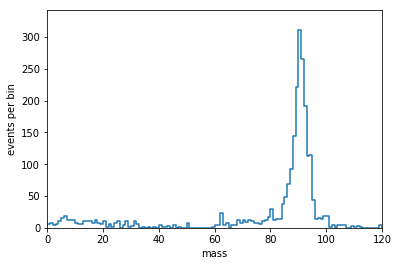

In [51]:
%matplotlib inline
import matplotlib.pyplot

counts, edges = histogram

matplotlib.pyplot.step(x=edges, y=numpy.append(counts, 0), where="post");
matplotlib.pyplot.xlim(edges[0], edges[-1]);
matplotlib.pyplot.ylim(0, counts.max() * 1.1);
matplotlib.pyplot.xlabel("mass");
matplotlib.pyplot.ylabel("events per bin");

This differs from the lazy array approach in that you need to explicitly manage the iteration, as in this histogram accumulation. However, since we aren't caching, the previous array batch is deleted as soon as `data` goes out of scope, so it is easier to control which arrays are in memory and which aren't.

Choose lazy arrays or iteration according to the degree of control you need.

## Filenames and entry numbers while iterating

[uproot.iterate](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot.tree.iterate) crosses file boundaries as part of its iteration, and that's information we might need in the loop. If the following are `True`, each step in iteration is a tuple containing the arrays and the additional information.

   * **reportpath:** the full path or URL of the (possibly remote) file;
   * **reportfile:** the [uproot.rootio.ROOTDirectory](https://uproot.readthedocs.io/en/latest/root-io.html#uproot-rootio-rootdirectory) object itself (so that you don't need to re-open it at each iteration step);
   * **reportentries:** the starting and stopping entry numbers for this chunk of data. In a multi-file iteration, these are global (always increasing, not returning to zero as we start the next file).

In [52]:
for path, file, start, stop, arrays in uproot.iterate(
    ["http://scikit-hep.org/uproot/examples/sample-%s-zlib.root" % x
        for x in ["5.23.02", "5.24.00", "5.25.02", "5.26.00", "5.27.02", "5.28.00",
                  "5.29.02", "5.30.00", "6.08.04", "6.10.05", "6.14.00"]],
    "sample",
    "f8",
     reportpath=True, reportfile=True, reportentries=True):
    print(path, file, start, stop, len(arrays))

http://scikit-hep.org/uproot/examples/sample-5.23.02-zlib.root <ROOTDirectory b'sample-5.23.02-zlib.root' at 0x78fb3f44a3c8> 0 30 1
http://scikit-hep.org/uproot/examples/sample-5.24.00-zlib.root <ROOTDirectory b'sample-5.24.00-zlib.root' at 0x78fb3f411fd0> 30 60 1
http://scikit-hep.org/uproot/examples/sample-5.25.02-zlib.root <ROOTDirectory b'sample-5.25.02-zlib.root' at 0x78fb3f3ceb38> 60 90 1
http://scikit-hep.org/uproot/examples/sample-5.26.00-zlib.root <ROOTDirectory b'sample-5.26.00-zlib.root' at 0x78fb3f324748> 90 120 1
http://scikit-hep.org/uproot/examples/sample-5.27.02-zlib.root <ROOTDirectory b'sample-5.27.02-zlib.root' at 0x78fb3f359358> 120 150 1
http://scikit-hep.org/uproot/examples/sample-5.28.00-zlib.root <ROOTDirectory b'sample-5.28.00-zlib.root' at 0x78fb3f29df28> 150 180 1
http://scikit-hep.org/uproot/examples/sample-5.29.02-zlib.root <ROOTDirectory b'sample-5.29.02-zlib.root' at 0x78fb3f359390> 180 210 1
http://scikit-hep.org/uproot/examples/sample-5.30.00-zlib.root 

## Limiting the number of entries to be read

All array-reading functions have the following parameters:

   * **entrystart:** the first entry to read, by default `0`;
   * **entrystop:** one after the last entry to read, by default `numentries`.

Setting **entrystart** and/or **entrystop** differs from slicing the resulting array in that slicing reads, then discards, but these parameters minimize the data to read.

In [53]:
len(events.array("E1", entrystart=100, entrystop=300))

200

As with Python slices, the **entrystart** and **entrystop** can be negative to count from the end of the TTree.

In [87]:
events.arrays("Event", entrystart=-10)

{b'Event': array([95800704, 95800704, 99768888, 99768888, 99768888, 99768888,
        99991333, 99991333, 99991333, 99991333], dtype=int32)}

Internally, ROOT files are written in chunks and whole chunks must be read, so the best places to set **entrystart** and **entrystop** are between basket boundaries.

In [54]:
# This file has small TBaskets
tree = uproot.open("http://scikit-hep.org/uproot/examples/foriter.root")["foriter"]
branch = tree["data"]
[branch.basket_numentries(i) for i in range(branch.numbaskets)]

[6, 6, 6, 6, 6, 6, 6, 4]

In [55]:
# (entrystart, entrystop) pairs where ALL the TBranches' TBaskets align
list(tree.clusters())

[(0, 6), (6, 12), (12, 18), (18, 24), (24, 30), (30, 36), (36, 42), (42, 46)]

Or simply,

In [56]:
branch.baskets()

[array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([ 6,  7,  8,  9, 10, 11], dtype=int32),
 array([12, 13, 14, 15, 16, 17], dtype=int32),
 array([18, 19, 20, 21, 22, 23], dtype=int32),
 array([24, 25, 26, 27, 28, 29], dtype=int32),
 array([30, 31, 32, 33, 34, 35], dtype=int32),
 array([36, 37, 38, 39, 40, 41], dtype=int32),
 array([42, 43, 44, 45], dtype=int32)]

## Controlling lazy chunk and iteration step sizes

In addition to **entrystart** and **entrystop**, the lazy array and iteration functions also have:

   * **entrysteps:** the number of entries to read in each chunk or step, `numpy.inf` for make the chunks/steps as big as possible (limited by file boundaries), or a list of `(entrystart, entrystop)` pairs to be explicit.

In [57]:
[len(chunk) for chunk in events.lazyarrays(entrysteps=500).chunks]

[500, 500, 500, 500, 304]

In [58]:
[len(data["E1"]) for data in events.iterate(["E*", "p[xyz]*"], entrysteps=500, namedecode="utf-8")]

[500, 500, 500, 500, 304]

The TTree lazy array/iteration functions ([TTreeMethods.array](https://uproot.readthedocs.io/en/latest/ttree-handling.html#array), [TTreeMethods.arrays](https://uproot.readthedocs.io/en/latest/ttree-handling.html#arrays), [TBranch.lazyarray](https://uproot.readthedocs.io/en/latest/ttree-handling.html#id13), [TTreeMethods.lazyarray](https://uproot.readthedocs.io/en/latest/ttree-handling.html#lazyarray), and [TTreeMethods.lazyarrays](https://uproot.readthedocs.io/en/latest/ttree-handling.html#lazyarrays)) use basket or cluster sizes as a default **entrysteps**, while multi-file lazy array/iteration functions ([uproot.lazyarrays](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-lazyarray-and-lazyarrays) and [uproot.iterate](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-iterate)) use the maximum per file: `numpy.inf`.

In [59]:
# This file has small TBaskets
tree = uproot.open("http://scikit-hep.org/uproot/examples/foriter.root")["foriter"]
branch = tree["data"]
[len(a["data"]) for a in tree.iterate(namedecode="utf-8")]

[6, 6, 6, 6, 6, 6, 6, 4]

In [60]:
# This file has small TBaskets
[len(a["data"]) for a in uproot.iterate(["http://scikit-hep.org/uproot/examples/foriter.root"] * 3,
                                        "foriter", namedecode="utf-8")]

[46, 46, 46]

## Caching and iteration

Since iteration gives you more precise control over which set of events you're processing at a given time, caching with the **cache** parameter is less useful than it is with lazy arrays. For consistency's sake, the [TTreeMethods.iterate](https://uproot.readthedocs.io/en/latest/ttree-handling.html#iterate) and [uproot.iterate](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-iterate) functions provide a **cache** parameter and it works the same way that it does in other array-reading functions, but its effect would be to retain the previous step's arrays while working on a new step in the iteration. Presumably, the reason you're iterating is because only the current step fits into memory, so this is not a useful feature.

However, the **basketcache** is very useful for iteration, more so than it is for lazy arrays. If an iteration step falls in the middle of a TBasket, the whole TBasket must be read in that step, despite the fact that only part of it is incorporated into the output array. The remainder of the TBasket will be used in the next iteration step, so caching it for exactly one iteration step is ideal: it avoids the need to reread it and decompress it again.

It is such a useful feature that it's built into [TTreeMethods.iterate](https://uproot.readthedocs.io/en/latest/ttree-handling.html#iterate) and [uproot.iterate](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-iterate) by default. If you don't set a **basketcache**, these functions will create one with no memory limit and save TBaskets in it for exactly one iteration step, eliminating that temporary cache at the end of iteration. (The same is true of the **keycache**; see [reference documentation](https://uproot.readthedocs.io/en/latest/caches.html) for detail.)

Thus, you probably don't want to set any explicit caches while iterating. Setting an explicit **basketcache** would introduce an upper limit on how much it can store, but it would lose the property of evicting after exactly one iteration step (because the connection between the cache object and the iterator would be lost). If you're running out of memory during iteration, try reducing the **entrysteps**.

# Changing the output container type

When we ask for [TTreeMethods.arrays](https://uproot.readthedocs.io/en/latest/ttree-handling.html#arrays), [TTreeMethods.iterate](https://uproot.readthedocs.io/en/latest/ttree-handling.html#iterate), or [uproot.iterate](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-iterate) (plural), we get a Python dict mapping branch names to arrays. (As a reminder, **namedecode="utf-8"** makes those branch names Python strings, rather than bytestrings.) Sometimes, we want a different kind of container.

   * **outputtype:** the _type_ of the container to hold the output arrays.

One particularly useful container is `tuple`, which can be unpacked by a tuple-assignment.

In [61]:
px, py, pz = events.arrays("p[xyz]1", outputtype=tuple)

In [67]:
px

array([-41.19528764,  35.11804977,  35.11804977, ...,  32.37749196,
        32.37749196,  32.48539387])

In [63]:
for px, py, pz in events.iterate("p[xyz]1", outputtype=tuple):
    px**2 + py**2 + pz**2

Another is `collections.namedtuple`, which packs everything into a single object, but the fields are accessible by name.

In [65]:
import collections    # from the Python standard library

a = events.arrays("p[xyz]1", outputtype=collections.namedtuple)

In [66]:
a.px1

array([-41.19528764,  35.11804977,  35.11804977, ...,  32.37749196,
        32.37749196,  32.48539387])

You can define your own classes.

In [68]:
class Stuff:
    def __init__(self, px, py, pz):
        self.p = numpy.sqrt(px**2 + py**2 + pz**2)
    def __repr__(self):
        return "<Stuff %r>" % self.p

events.arrays("p[xyz]1", outputtype=Stuff)

<Stuff array([82.20179848, 62.34483942, 62.34483942, ..., 81.27006689,
       81.27006689, 81.56614892])>

And perhaps most importantly, you can pass in [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [72]:
import pandas

events.arrays("p[xyz]1", outputtype=pandas.DataFrame, entrystop=10)

,px1,py1,pz1
entry,,,
0,-41.195288,17.433244,-68.964962
1,35.118050,-16.570362,-48.775247
2,35.118050,-16.570362,-48.775247
3,34.144437,-16.119525,-47.426984
4,22.783582,15.036444,-31.689894
5,-19.862307,-9.204225,43.817098
6,-19.862307,-9.204225,43.817098
7,-20.177373,-9.354149,44.513955
8,71.143711,29.542308,-108.150553


# Filling Pandas DataFrames

The previous example filled a [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) by explicitly passing it as an **outputtype**. Pandas is such an important container type that there are specialized functions for it: [TTreeMethods.pandas.df](https://uproot.readthedocs.io/en/latest/ttree-handling.html#id7) and [uproot.pandas.df](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-pandas-iterate).

In [88]:
events.pandas.df("p[xyz]1", entrystop=10)

,px1,py1,pz1
entry,,,
0,-41.195288,17.433244,-68.964962
1,35.118050,-16.570362,-48.775247
2,35.118050,-16.570362,-48.775247
3,34.144437,-16.119525,-47.426984
4,22.783582,15.036444,-31.689894
5,-19.862307,-9.204225,43.817098
6,-19.862307,-9.204225,43.817098
7,-20.177373,-9.354149,44.513955
8,71.143711,29.542308,-108.150553


The **entry** index in the resulting DataFrame represents the actual entry numbers in the file. For instance, counting from the end:

In [89]:
events.pandas.df("p[xyz]1", entrystart=-10)

,px1,py1,pz1
entry,,,
2294,12.966984,30.974506,11.094139
2295,13.001270,31.059021,11.123455
2296,-16.891371,-15.335677,-15.784044
2297,19.037577,14.820723,22.037447
2298,19.037577,14.820723,22.037447
2299,19.054651,14.833954,22.051323
2300,-68.041915,-26.105847,-152.235018
2301,32.377492,1.199406,-74.532431
2302,32.377492,1.199406,-74.532431


The [uproot.pandas.df](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-pandas-iterate) function doesn't have a **reportentries** because they're included in the DataFrame itself.

In [91]:
for df in uproot.pandas.iterate("http://scikit-hep.org/uproot/examples/Zmumu.root", "events", "p[xyz]1", entrysteps=500):
    print(df[:3])

             px1        py1        pz1
entry                                 
0     -41.195288  17.433244 -68.964962
1      35.118050 -16.570362 -48.775247
2      35.118050 -16.570362 -48.775247
             px1        py1        pz1
entry                                 
500    39.163212 -19.185280 -13.979333
501    39.094970 -19.152964 -13.936115
502    -7.656437 -33.431880  91.840257
             px1        py1       pz1
entry                                
1000   26.043759 -17.618814 -0.567176
1001   26.043759 -17.618814 -0.567176
1002   25.996204 -17.585241 -0.568920
             px1        py1        pz1
entry                                 
1500   82.816840  13.262734  27.797909
1501  -11.416911  39.815352  32.349893
1502  -11.416911  39.815352  32.349893
             px1        py1       pz1
entry                                
2000  -43.378378 -15.235422  3.019698
2001  -43.378378 -15.235422  3.019698
2002  -43.244422 -15.187402  3.003985


Part of the motivation for a special function is that it's the first of potentially many external connectors (Dask is another: see above). The other part is that these functions have more Pandas-friendly default parameters, such as **flatten=True**.

Flattening turns multiple values per entry (i.e. multiple particles per event) into separate DataFrame rows, maintaining the nested structure in the DataFrame index. Flattening is usually undesirable for arrays—because arrays don't have an index to record that information—but it's usually desirable for DataFrames.

In [92]:
events2 = uproot.open("http://scikit-hep.org/uproot/examples/HZZ.root")["events"]   # non-flat data

In [95]:
events2.pandas.df(["MET_p*", "Muon_P*"], entrystop=10, flatten=False)   # not the default

,MET_px,MET_py,Muon_Px,Muon_Py,Muon_Pz
entry,,,,,
0,5.912771,2.563633,"[-52.899456, 37.73778]","[-11.654672, 0.6934736]","[-8.160793, -11.307582]"
1,24.765203,-16.349110,[-0.81645936],[-24.404259],[20.199968]
2,-25.785088,16.237131,"[48.98783, 0.8275667]","[-21.723139, 29.800508]","[11.168285, 36.96519]"
3,8.619896,-22.786547,"[22.088331, 76.69192]","[-85.835464, -13.956494]","[403.84845, 335.0942]"
4,5.393139,-1.310052,"[45.17132, 39.750957]","[67.24879, 25.403667]","[-89.69573, 20.115053]"
5,-3.759475,-19.417021,"[9.22811, -5.793715]","[40.55438, -30.295189]","[-14.642164, 42.954376]"
6,23.962149,-9.049156,"[12.538717, 29.54184]","[-42.54871, -4.4455166]","[-124.44899, -26.356554]"
7,-57.533348,-20.487679,[34.88376],[-15.982724],[155.53117]
8,42.416195,-94.350861,"[-53.166973, 11.49187]","[92.02971, -4.4173865]","[35.638836, -17.473787]"


DataFrames like the above are slow (the cell entries are Python lists) and difficult to use in Pandas. Pandas doesn't have specialized functions for manipulating this kind of structure.

However, if we use the default **flatten=True**:

In [99]:
df = events2.pandas.df(["MET_p*", "Muon_P*"], entrystop=10)
df

MET_px     MET_py    Muon_Px    Muon_Py     Muon_Pz
entry subentry                                                        
0     0          5.912771   2.563633 -52.899456 -11.654672   -8.160793
      1          5.912771   2.563633  37.737782   0.693474  -11.307582
1     0         24.765203 -16.349110  -0.816459 -24.404259   20.199968
2     0        -25.785088  16.237131  48.987831 -21.723139   11.168285
      1        -25.785088  16.237131   0.827567  29.800508   36.965191
3     0          8.619896 -22.786547  22.088331 -85.835464  403.848450
      1          8.619896 -22.786547  76.691917 -13.956494  335.094208
4     0          5.393139  -1.310052  45.171322  67.248787  -89.695732
      1          5.393139  -1.310052  39.750957  25.403667   20.115053
5     0         -3.759475 -19.417021   9.228110  40.554379  -14.642164
      1         -3.759475 -19.417021  -5.793715 -30.295189   42.954376
6     0         23.962149  -9.049156  12.538717 -42.548710 -124.448990
      1         23.962149  -9.049156  29.541840  -4.445517  -26.356554
7     0        -57.533348 -20.487679  34.883759 -15.982724  155.531174
8     0         42.416195 -94.350861 -53.166973  92.029709   35.638836
      1         42.416195 -94.350861  11.491870  -4.417387  -17.473787
9     0         -1.914469 -23.963034 -67.014854  53.159172   54.412941
      1         -1.914469 -23.963034 -18.118755 -35.106167   58.036896

The particles-within-events structure is encoded in the [pandas.MultiIndex](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html), and we can use Pandas functions like [DataFrame.unstack](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html) to manipulate that structure.

In [100]:
df.unstack()

MET_px                MET_py               Muon_Px             \
subentry          0          1          0          1          0          1   
entry                                                                        
0          5.912771   5.912771   2.563633   2.563633 -52.899456  37.737782   
1         24.765203        NaN -16.349110        NaN  -0.816459        NaN   
2        -25.785088 -25.785088  16.237131  16.237131  48.987831   0.827567   
3          8.619896   8.619896 -22.786547 -22.786547  22.088331  76.691917   
4          5.393139   5.393139  -1.310052  -1.310052  45.171322  39.750957   
5         -3.759475  -3.759475 -19.417021 -19.417021   9.228110  -5.793715   
6         23.962149  23.962149  -9.049156  -9.049156  12.538717  29.541840   
7        -57.533348        NaN -20.487679        NaN  34.883759        NaN   
8         42.416195  42.416195 -94.350861 -94.350861 -53.166973  11.491870   
9         -1.914469  -1.914469 -23.963034 -23.963034 -67.014854 -18.118755   

            Muon_Py                Muon_Pz              
subentry          0          1           0           1  
entry                                                   
0        -11.654672   0.693474   -8.160793  -11.307582  
1        -24.404259        NaN   20.199968         NaN  
2        -21.723139  29.800508   11.168285   36.965191  
3        -85.835464 -13.956494  403.848450  335.094208  
4         67.248787  25.403667  -89.695732   20.115053  
5         40.554379 -30.295189  -14.642164   42.954376  
6        -42.548710  -4.445517 -124.448990  -26.356554  
7        -15.982724        NaN  155.531174         NaN  
8         92.029709  -4.417387   35.638836  -17.473787  
9         53.159172 -35.106167   54.412941   58.036896

There's also a **flatten=None** that skips all non-flat TBranches, included as a convenience against overzealous branch selection.

In [101]:
events2.pandas.df(["MET_p*", "Muon_P*"], entrystop=10, flatten=None)

,MET_px,MET_py
entry,,
0,5.912771,2.563633
1,24.765203,-16.349110
2,-25.785088,16.237131
3,8.619896,-22.786547
4,5.393139,-1.310052
5,-3.759475,-19.417021
6,23.962149,-9.049156
7,-57.533348,-20.487679
8,42.416195,-94.350861


# Selecting and interpreting branches

asarray

## Multiple values per event (jaggedness)

## Fixed-size arrays

## Multiple TLeaf (leaf-list) TBranches

## Strings

## Lorentz vectors

(both kinds)

## Arbitrary objects

# Parallel array reading

# Reading and writing histograms